In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import pathlib
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.activations import *
from sklearn.metrics import precision_score, recall_score, jaccard_score
from datetime import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install natsort
import natsort

images_dir_path = '/content/drive/MyDrive/mm/Viral_Pneumonia/images'
masks_dir_path = '/content/drive/MyDrive/mm/Viral_Pneumonia/masks'

images_dir = os.listdir(images_dir_path)
masks_dir = os.listdir(masks_dir_path)

print("="*32+"\nTotal number of Images : ", len(images_dir))
print("="*32+"\nTotal number of Masks : ", len(masks_dir))

Total number of Images :  1345
Total number of Masks :  1345


/content/drive/MyDrive/mm/Viral_Pneumonia/images/Viral Pneumonia-1.png
/content/drive/MyDrive/mm/Viral_Pneumonia/masks/Viral Pneumonia-1.png


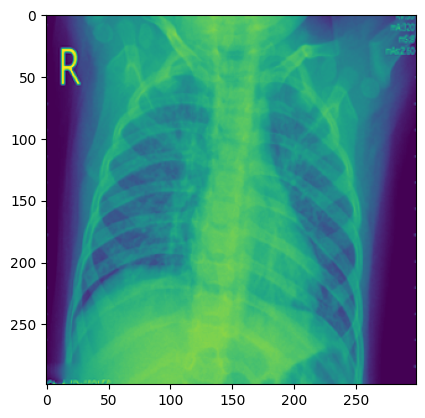

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

images_dir = natsort.natsorted(images_dir)
masks_dir = natsort.natsorted(masks_dir)

images_path = []

for i in range(len(images_dir)):
    temp_path = os.path.join(images_dir_path, images_dir[i])
    images_path.append(temp_path)

masks_path = []

for i in range(len(masks_dir)):
    temp_mask = os.path.join(masks_dir_path, masks_dir[i])
    masks_path.append(temp_mask)

print(images_path[0] + "\n" + masks_path[0])

plt.imshow(plt.imread(images_path[0]))


In [6]:
img_row = 256
img_col = 256
img_chan = 3
target_shape = (img_row, img_col, img_chan)
num_imgs = len(images_path)

images = np.zeros((num_imgs, img_row, img_col))
masks = np.zeros_like(images)

def load_imgs_masks(DIR, array):
    for i in range(len(DIR)):
        temp_img = image.load_img(DIR[i], target_size=target_shape)
        img = image.img_to_array(temp_img)
        array[i] = img[:, :, 0] / 255.0

    array = np.expand_dims(array, axis=3)
    return array

images = load_imgs_masks(images_path, images)
masks = load_imgs_masks(masks_path, masks)


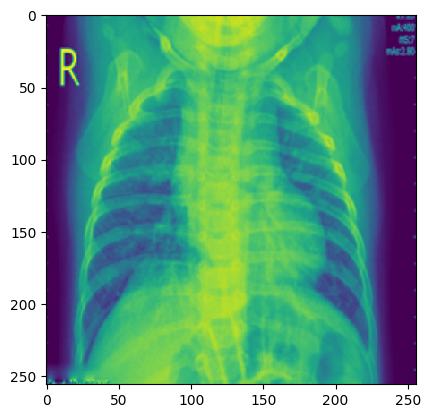

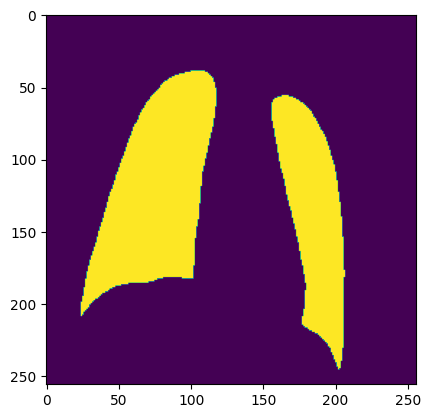

In [7]:
plt.imshow(images[np.random.randint(0, 1345)])
plt.show()
plt.imshow(masks[np.random.randint(0, 1345)])
plt.show()

In [8]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.3, random_state=SEED)

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
def build_model(start_neurons):
    input_layer = Input((256, 256, 1))

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [11]:
model = build_model(16)

EPOCHS = 15
model.compile(optimizer=Adam(learning_rate=5*1e-4), loss="binary_crossentropy",
              metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 2,158,417 (8.23 MB)

 Trainable params: 2,158,417 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
weight_path = "{}_weights.best.weights.h5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', #verbose=1,
                             save_best_only=True, #mode='min',
                             save_weights_only=True)

early = EarlyStopping(monitor="loss",
                      #mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [13]:
curr_time = datetime.now()
print("Starting time : ", curr_time)
history = model.fit(x=train_images,
                    y=train_masks,
                    validation_data=(test_images, test_masks),
                    epochs=20,
                    batch_size=16,
                    callbacks=callbacks_list)
time_now = datetime.now()
print("Ending time : ", time_now)
print("="*40 + "Time taken : ", time_now - curr_time)
model.save('my_model.h5')

model.evaluate(test_images, test_masks)

Starting time :  2024-07-31 21:47:53.057647
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 70s 650ms/step - binary_accuracy: 0.6549 - dice_coef: 0.2790 - loss: 0.6135 - val_binary_accuracy: 0.7678 - val_dice_coef: 0.3455 - val_loss: 0.4629
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - binary_accuracy: 0.7662 - dice_coef: 0.3588 - loss: 0.4364 - val_binary_accuracy: 0.7678 - val_dice_coef: 0.4404 - val_loss: 0.3457
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - binary_accuracy: 0.7872 - dice_coef: 0.4752 - loss: 0.3293 - val_binary_accuracy: 0.9206 - val_dice_coef: 0.6150 - val_loss: 0.2540
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - binary_accuracy: 0.9201 - dice_coef: 0.7351 - loss: 0.2045 - val_binary_accuracy: 0.9520 - val_dice_coef: 0.8046 - val_loss: 0.1353
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - binary_accuracy: 0.9476 - dice_coef: 0.8340 - loss: 0.1314 - val_binary_accuracy: 0.9550 - val_dice_coef: 0.8289 - val_loss: 0.1178
Epoch 6/20
59/59 ━━━━━━━━

Ending time :  2024-07-31 21:52:06.860829
========================================Time taken :  0:04:13.803182
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 712ms/step - binary_accuracy: 0.9704 - dice_coef: 0.9187 - loss: 0.0801


[0.0772327184677124, 0.9203265309333801, 0.9712797403335571]

In [16]:
def precision(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return precision_score(y_true_f, y_pred_f)

def recall(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return recall_score(y_true_f, y_pred_f)

def iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return jaccard_score(y_true_f, y_pred_f)


In [14]:
def test_on_image(model, img_array, img_num, img_side_size = 256):
    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))

    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Forecast")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(test_masks[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(test_masks[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "PuBu", alpha = 0.3)
    plt.title("Overlap")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")

    precision_value = precision(test_masks[img_num], pred)
    recall_value = recall(test_masks[img_num], pred)
    iou_value = iou(test_masks[img_num], pred)

    print(f"Precision: {precision_value:.4f}")
    print(f"Recall: {recall_value:.4f}")
    print(f"IoU: {iou_value:.4f}")

    return pred


In [28]:
def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union == 0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union


In [26]:
print(f"Dice Coefficient: {dice_coef_test(test_masks[IMG_NUM], prediction):.4f}")


Dice Coefficient: 0.9142


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Precision: 0.9908
Recall: 0.8486
IoU: 0.8420


0.9142102947646282

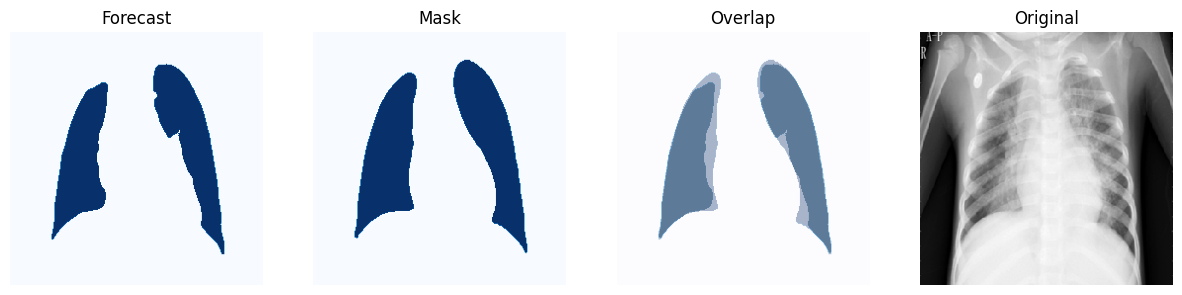

In [29]:
IMG_NUM = 3  # Example image number
prediction = test_on_image(model, img_array=test_images, img_num=IMG_NUM, img_side_size=256)
dice_coef_test(y_true=test_masks[IMG_NUM], y_pred=prediction)

In [24]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Entropy crusade binary")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Cofficient Dice Score")

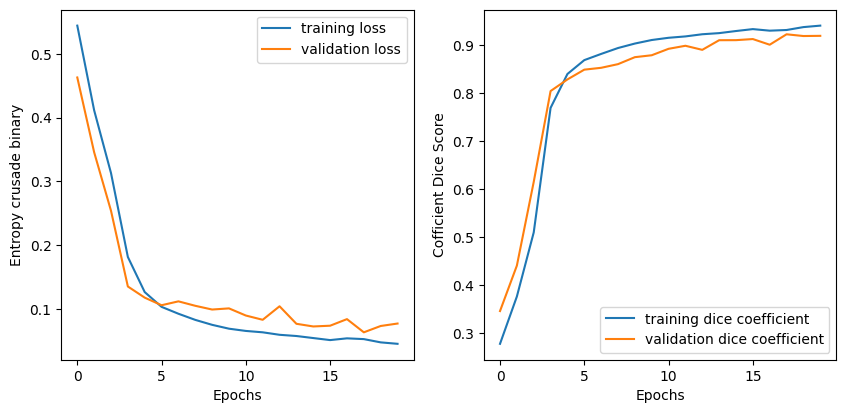

In [25]:
get_metrics(history = history)